In [6]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [7]:
from parse_utils import parse_benchmark_results
from utils import abs_listdir
csv_results = abs_listdir('results')

In [8]:
df = pd.read_csv(csv_results[1])
df

,node type,start,first,avg_ms,%,cdf%,mem KB,times called,name
0,DEPTHWISE_CONV_2D,0.000000,0.058,0.040128,28.6661%,28.6661%,0,1,[sequential_18/depthwise_conv2d_63/depthwise]:0
1,CONV_2D,0.040193,0.032,0.031924,22.8053%,51.4713%,0,1,[sequential_18/conv2d_54/Conv2D]:1
2,TANH,0.072185,0.009,0.008540,6.10062%,57.5719%,0,1,[sequential_18/conv2d_54/Tanh]:2
3,AVERAGE_POOL_2D,0.080768,0.026,0.026812,19.1536%,76.7255%,0,1,[sequential_18/average_pooling2d_36/AvgPool]:3
4,DEPTHWISE_CONV_2D,0.107632,0.012,0.011578,8.27071%,84.9963%,0,1,[sequential_18/depthwise_conv2d_64/depthwise]:4
5,CONV_2D,0.119266,0.008,0.007971,5.6944%,90.6907%,0,1,[sequential_18/conv2d_55/Conv2D]:5
6,TANH,0.127284,0.003,0.002956,2.11168%,92.8023%,0,1,[sequential_18/conv2d_55/Tanh]:6
7,AVERAGE_POOL_2D,0.130280,0.003,0.003502,2.5019%,95.3042%,0,1,[sequential_18/average_pooling2d_37/AvgPool]:7
8,DEPTHWISE_CONV_2D,0.133820,0.002,0.001393,0.994977%,96.2992%,0,1,[sequential_18/depthwise_conv2d_65/depthwise]:8
9,CONV_2D,0.135247,0.002,0.002083,1.48795%,97.7872%,0,1,[sequential_18/conv2d_56/Conv2D]:9


In [9]:
dfs = {os.path.split(r)[1] : pd.read_csv(r) for r in csv_results}
conv_time_total = {}
conv_percentage_total = {}
conv_type = {}
activation_time_total = {}
activation_percentage_total = {}
activation = {}


for filename, df in dfs.items():
    # convolution statistics
    df_convs = df[df['node type'].apply(lambda s: 'CONV' in s)]
    conv_time_total[filename] = df_convs[' avg_ms'].sum()
    conv_percentage_total[filename] = df_convs[' %'].apply(lambda s: float(s[:-1])).sum()
    conv_type[filename] = '_'.join(filename.split('_')[1:-1]) or 'regular'
    
    # activation statistics
    df_activations = df[df['node type'].apply(lambda s: s in ['ELU', 'RELU', 'TANH'])]
    activation_time_total[filename] = df_activations[' avg_ms'].sum()
    activation_percentage_total[filename] = df_activations[' %'].apply(lambda s: float(s[:-1])).sum()
    activation[filename] = filename.split('_', maxsplit=1)[0].upper()

result = pd.DataFrame({'conv_type': conv_type,
                       'conv_time_total': conv_time_total, 
                       'conv_percentage_total': conv_percentage_total,
                       'activation': activation,
                       'activation_time_total': activation_time_total,
                       'activation_percentage_total': activation_percentage_total})
result.sort_index(inplace=True)
result

,conv_type,conv_time_total,conv_percentage_total,activation,activation_time_total,activation_percentage_total
relu_depthwise_benchmark.csv,depthwise,0.218655,87.098619,RELU,0.000000,0.000000
tanh_spatial_benchmark.csv,spatial,0.095076,67.919437,TANH,0.012062,8.616577
relu_benchmark.csv,regular,0.130651,79.754130,RELU,0.000000,0.000000
relu_spatial_benchmark.csv,spatial,0.094850,74.343390,RELU,0.000000,0.000000
elu_depthwise_benchmark.csv,depthwise,0.219151,75.759674,ELU,0.037401,12.929269
tanh_depthwise_spatial_benchmark.csv,depthwise_spatial,0.114622,72.170815,TANH,0.011885,7.483554
elu_depthwise_spatial_benchmark.csv,depthwise_spatial,0.115112,62.077943,ELU,0.037743,20.354061
elu_spatial_benchmark.csv,spatial,0.094540,56.161397,ELU,0.040834,24.257484
tanh_benchmark.csv,regular,0.129369,74.185010,TANH,0.012120,6.950237
relu_depthwise_spatial_benchmark.csv,depthwise_spatial,0.115034,78.024236,RELU,0.000000,0.000000


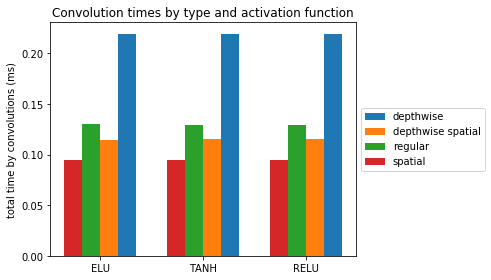

In [10]:
labels = ['ELU', 'TANH', 'RELU']
conv_types = result['conv_type'].unique()
# sort for consistent order
conv_types.sort()

x = np.arange(len(labels)) * 2  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects = {}
mid_padding = 0.0
for i, conv_type in enumerate(conv_types):
    pos = x - ((i-2)*(1+mid_padding) + 1/2) * width
    r = result[result['conv_type'] == conv_type]
    label = conv_type.replace('_', ' ')
    rects[conv_type] = ax.bar(pos, r['conv_time_total'], width, label=label)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('total time by convolutions (ms)')
ax.set_title('Convolution times by type and activation function')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


fig.tight_layout()
plt.show()